## 2 Data

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db=wrds.Connection(wrds_username='sahakyan')

In [2]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1964-01-01' and date<='2023-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

NameError: name 'db' is not defined

## 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [15]:
# load data
data = pd.read_csv('data.csv', sep=';')
data['date'] = pd.to_datetime(data['date'])
# get rid of the day in the date
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()

In [16]:
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)

In [17]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [18]:
len(data)

1118612

#### (B) Beta Deciles

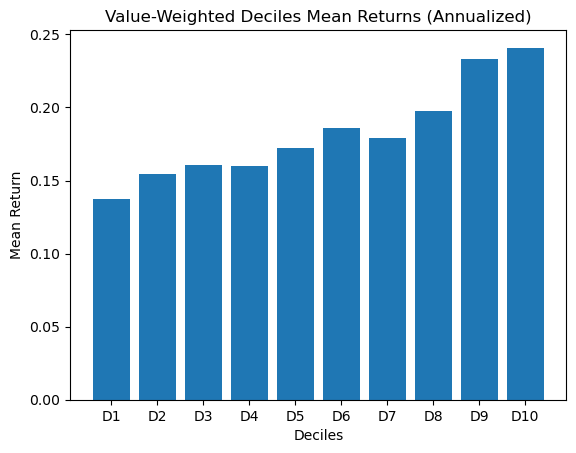

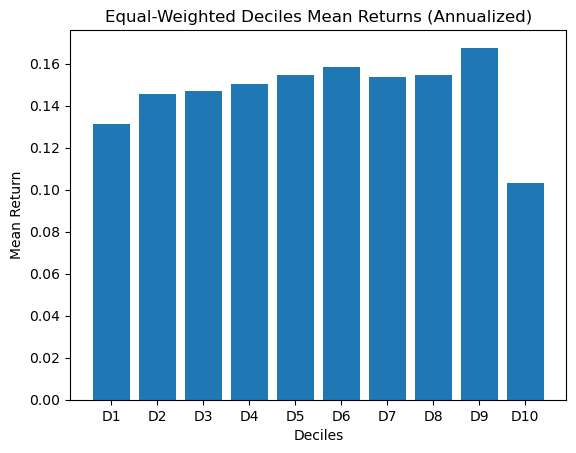

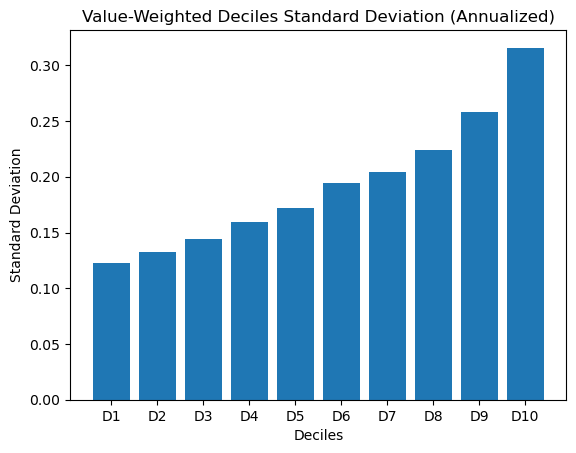

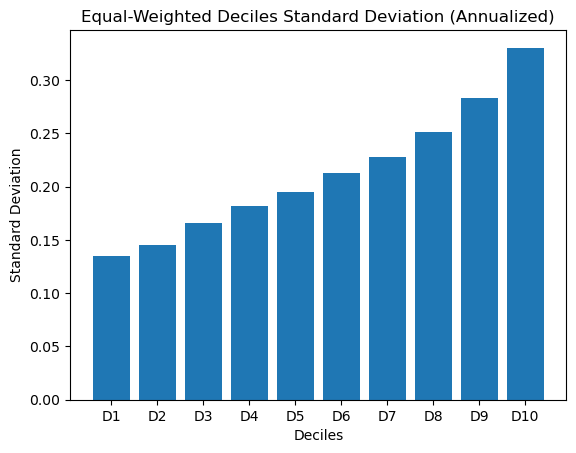

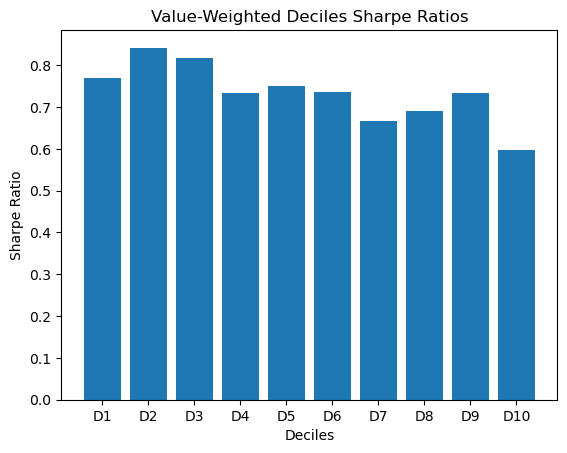

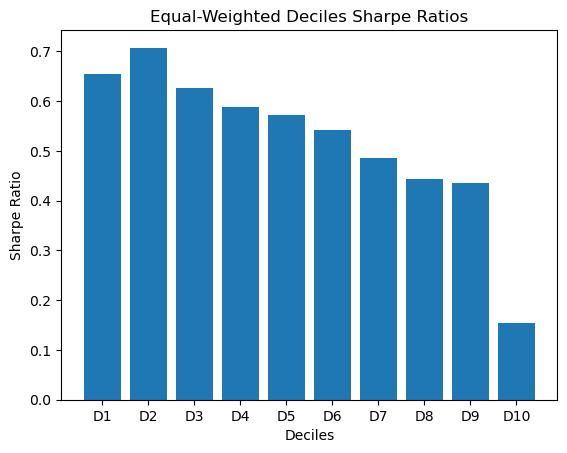

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part3'

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/ew_ret_std.png')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe* np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/vw_sharpe.png')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe* np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/ew_sharpe.png')
plt.show()

TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [20]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

# Sum up the weighted returns and betas but not the rf
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
# unlevered returns
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )


In [21]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean()*12)
print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.11874255392437737
Standard Deviation: 0.140733074838844
Sharpe ratio: 0.8437430508809078
Monthly CAPM Alpha: 0.08336383258253602


Save factor for our investing strategy

In [22]:
print(len(BAB))
strat = BAB[['date','rf','BAB2']]
strat

682


,date,rf,BAB2
0,1967-01-01,0.003788,0.073687
1,1967-02-01,0.003737,0.017388
2,1967-03-01,0.003385,0.012774
3,1967-04-01,0.002877,0.022528
4,1967-05-01,0.002707,0.004888
...,...,...,...
677,2023-08-01,0.004463,-0.015492
678,2023-09-01,0.004472,-0.043756
679,2023-10-01,0.004475,0.005475
680,2023-11-01,0.004455,0.034885


## Part 4: Momentum Strategy (Mom)

In [23]:
# Load data
data = pd.read_csv('data.csv', delimiter=';')
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno       0
date         0
Rn           0
shrout       0
prc          0
mcap         0
rf        2076
Rm           0
const        0
Rn_e      2076
Rm_e      2076
dtype: int64

,permno,date,Rn,shrout,prc,mcap,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-01,0.162621,4361.0,10.3000,44918.3000,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-01,-0.018932,4361.0,10.0600,43871.6600,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-01,-0.000656,4361.0,10.0084,43646.6324,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-01,0.020643,4361.0,10.1700,44351.3700,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-01,0.124385,6070.0,11.3900,69137.3000,0.000118,0.020036,1,0.124267,0.019918
...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.0200,453167.6200,0.004463,-0.020605,1,-0.041619,-0.025068
1432774,93426,2023-09-01,-0.067740,12581.0,33.5800,422469.9800,0.004472,-0.047390,1,-0.072212,-0.051862
1432775,93426,2023-10-01,-0.108993,12581.0,29.9200,376423.5200,0.004475,-0.028867,1,-0.113468,-0.033342
1432776,93426,2023-11-01,0.019051,12510.0,30.4900,381429.9000,0.004455,0.092057,1,0.014596,0.087602


In [24]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)

q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

C:\Users\41794\AppData\Local\Temp\ipykernel_17788\2223377266.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values


,permno,date,Rn,shrout,prc,mcap,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Momentum
12,10001,2010-12-01,0.052291,7834.0,10.52,82413.68,0.000068,0.067182,1,0.052223,0.067114,0.297149,7
13,10001,2011-01-01,0.028992,7834.0,10.78,84450.52,0.000125,0.019183,1,0.028867,0.019058,0.020414,3
14,10001,2011-02-01,0.022727,7834.0,10.98,86017.32,0.000065,0.038156,1,0.022662,0.038091,0.090498,2
15,10001,2011-03-01,0.072404,7834.0,11.73,91892.82,0.000049,0.003341,1,0.072355,0.003292,0.119734,3
16,10001,2011-04-01,-0.038789,8151.0,11.23,91535.73,0.000013,0.028597,1,-0.038802,0.028584,0.121773,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,0.004463,-0.020605,1,-0.041619,-0.025068,0.175187,7
1432774,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,0.004472,-0.047390,1,-0.072212,-0.051862,0.086501,5
1432775,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,0.004475,-0.028867,1,-0.113468,-0.033342,0.196638,5
1432776,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,0.004455,0.092057,1,0.014596,0.087602,-0.005050,5


In [25]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

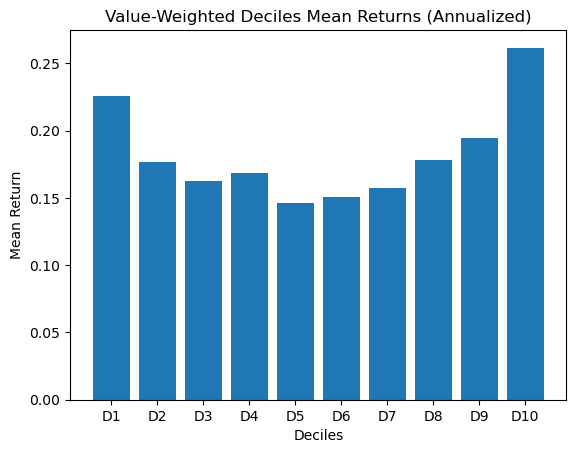

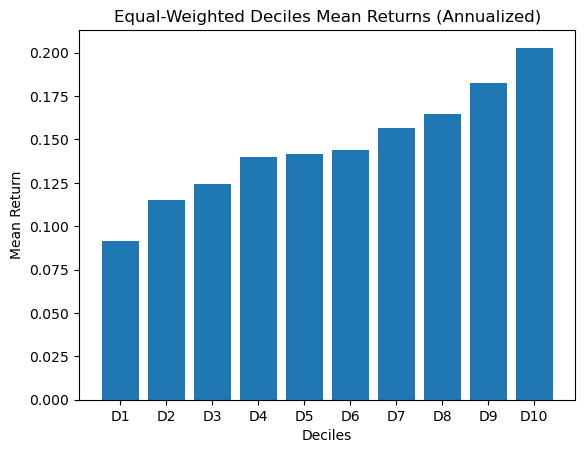

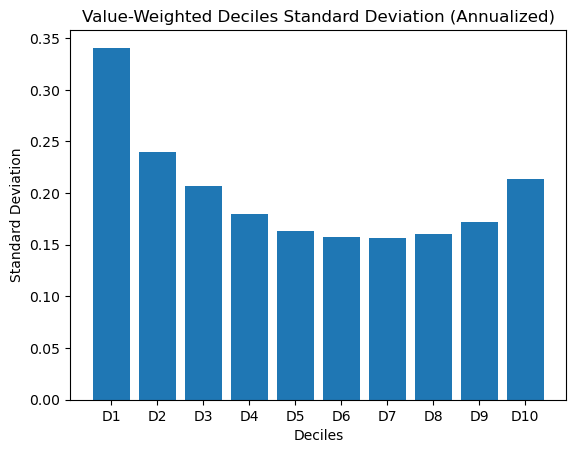

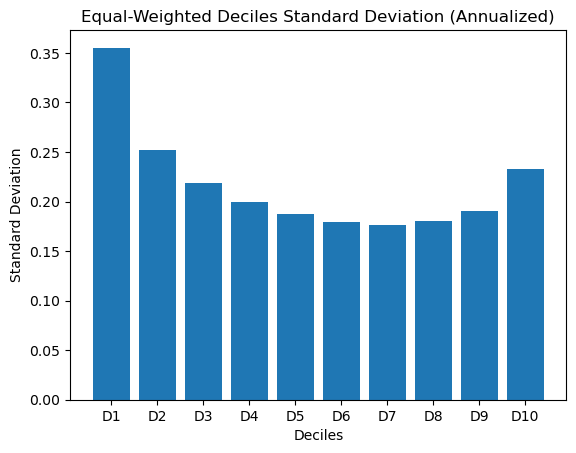

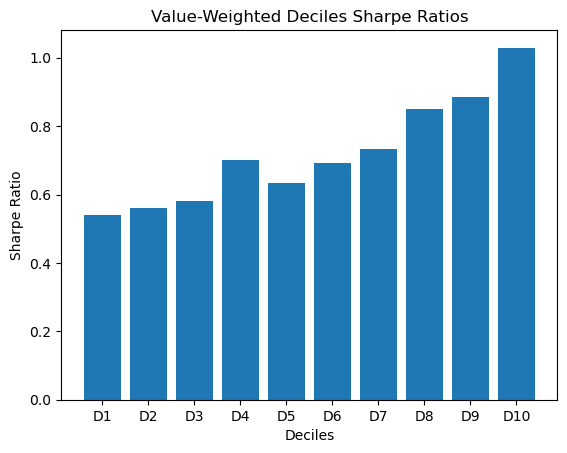

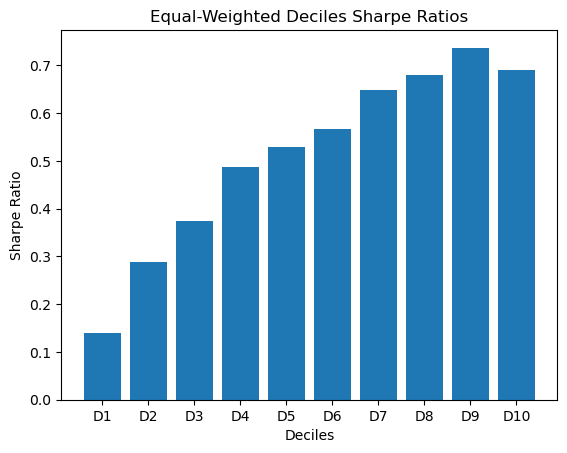

In [26]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part4/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [27]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean() * 12
short_mean = ew_short_leg['Rn'].mean() * 12

long_mean_e = ew_long_leg['excess'].mean() * 12
short_mean_e = ew_short_leg['excess'].mean() * 12

long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18349772813987653
Short Leg Mean Return: 0.11027267804475926
Long Leg Standard Deviation: 0.19754428425563075
Short Leg Standard Deviation: 0.26801944208572653
Long Leg Sharpe Ratio: 0.6729430761519647
Short Leg Sharpe Ratio: 0.2306584526124965
Factor Mean Return: 0.07322505009511728
Factor Standard Deviation: 0.1675909026499953
Factor Sharpe Ratio: 0.12688503321712993


In [28]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 11.625880810436598
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [29]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.6340076953377646
Short Leg Mean Return: 0.5653608046375727
Long Leg Standard Deviation: 0.5203218892594204
Short Leg Standard Deviation: 0.7494202595343373
Long Leg Sharpe Ratio: 1.1237936105157902
Short Leg Sharpe Ratio: 0.6791625155060891
Factor Mean Return: 0.06864689070019186
Factor Standard Deviation: 0.6036595189051944
Factor Sharpe Ratio: 0.042914811779374264


In [30]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 3.0258364250406324
P-Value: 0.0012397319966197529
The factor strategy has an average return that is statistically significantly different from zero.


In [31]:
# Merge factor dataframe with strat dataframe
strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')

In [32]:
strat

,date,rf,BAB2,MOM_ret_vw
0,1967-01-01,0.003788,0.073687,-0.244450
1,1967-02-01,0.003737,0.017388,0.076805
2,1967-03-01,0.003385,0.012774,0.049046
3,1967-04-01,0.002877,0.022528,-0.017797
4,1967-05-01,0.002707,0.004888,0.053441
...,...,...,...,...
677,2023-08-01,0.004463,-0.015492,0.172734
678,2023-09-01,0.004472,-0.043756,0.018452
679,2023-10-01,0.004475,0.005475,-0.026999
680,2023-11-01,0.004455,0.034885,0.051445


# Part 5: Idiosyncratic Volatility Strategy (IV)

In [33]:
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [34]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [35]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta
36,10001,2013-01-01,0.062701,8157.0,9.87,80509.59,81080.58,0.000051,0.054142,1,0.062650,0.054091,0.464682
37,10001,2013-02-01,0.011651,8157.0,9.94,81080.58,83201.40,0.000040,0.008282,1,0.011611,0.008242,0.484416
38,10001,2013-03-01,0.030684,8157.0,10.20,83201.40,86668.70,0.000034,0.035295,1,0.030650,0.035261,0.484182
39,10001,2013-04-01,0.017157,8390.0,10.33,86668.70,86249.20,0.000013,0.014939,1,0.017144,0.014926,0.487155
40,10001,2013-05-01,-0.000484,8390.0,10.28,86249.20,89064.10,0.000013,0.019128,1,-0.000497,0.019115,0.487298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420787,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988
1420788,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,376423.52,0.004472,-0.047390,1,-0.072212,-0.051862,1.306562
1420789,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,381429.90,0.004475,-0.028867,1,-0.113468,-0.033342,1.299385
1420790,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,426215.70,0.004455,0.092057,1,0.014596,0.087602,1.300548


In [36]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return_e'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return_e']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return_e', 'residuals'])

# Drop nans in the idiosyncratic_volatility and beta columns
data = data.dropna(subset=['idiosyncratic_volatility'])

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [37]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta,idiosyncratic_volatility
35,10001,2015-12-01,-0.132151,10505.0,7.45,78262.25,87401.60,0.000057,-0.022209,1,-0.132208,-0.022266,0.257458,0.073474
36,10001,2016-01-01,0.116779,10505.0,8.32,87401.60,82569.30,0.000190,-0.057085,1,0.116589,-0.057275,0.257458,0.075759
37,10001,2016-02-01,-0.055288,10505.0,7.86,82569.30,82067.48,0.000186,0.000620,1,-0.055474,0.000434,0.257458,0.075274
38,10001,2016-03-01,-0.006361,10508.0,7.81,82067.48,76737.60,0.000063,0.070491,1,-0.006424,0.070428,0.257458,0.074371
39,10001,2016-04-01,-0.055698,10512.0,7.30,76737.60,75055.68,0.000110,0.011718,1,-0.055808,0.011608,0.257458,0.073961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118607,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988,0.064385
1118608,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,376423.52,0.004472,-0.047390,1,-0.072212,-0.051862,1.306562,0.062242
1118609,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,381429.90,0.004475,-0.028867,1,-0.113468,-0.033342,1.299385,0.062429
1118610,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,426215.70,0.004455,0.092057,1,0.014596,0.087602,1.300548,0.063323


## Sorting

In [38]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

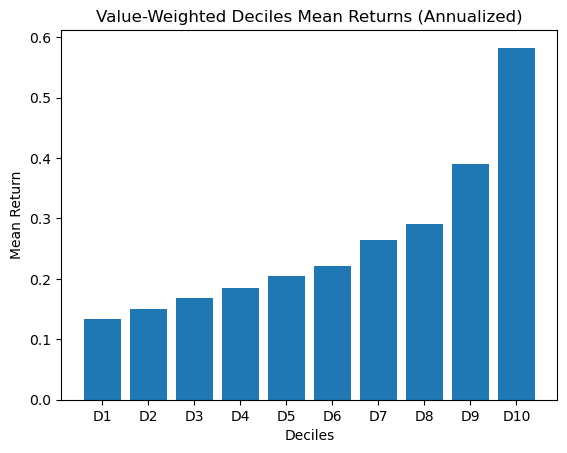

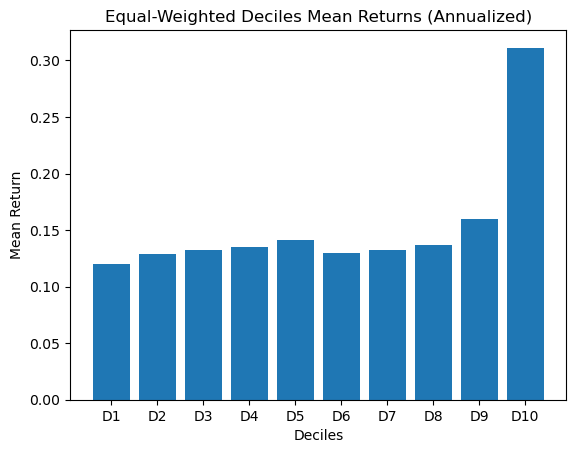

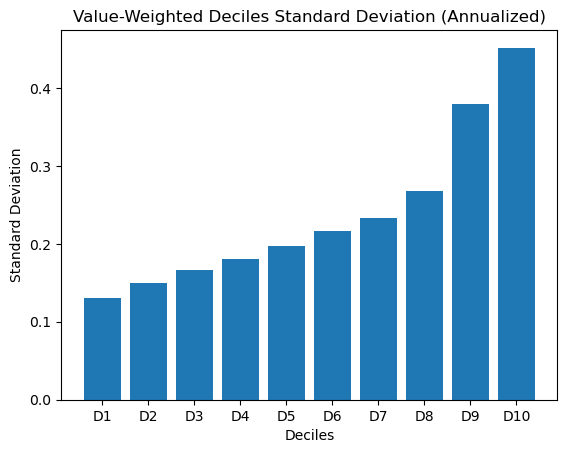

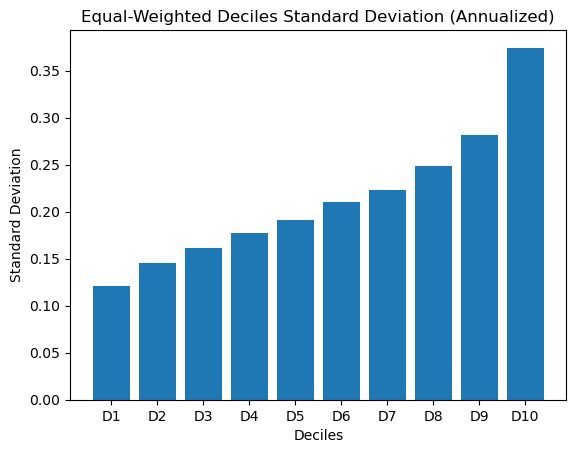

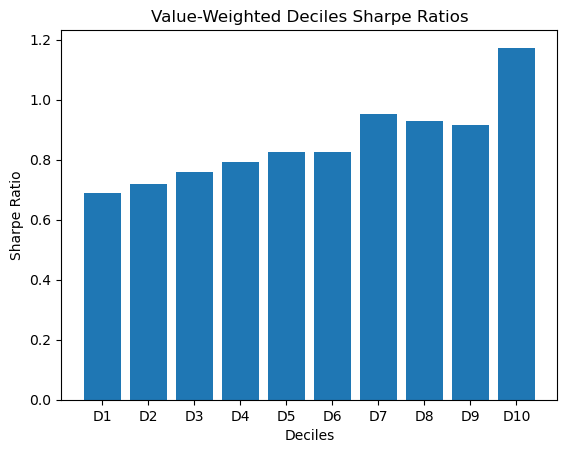

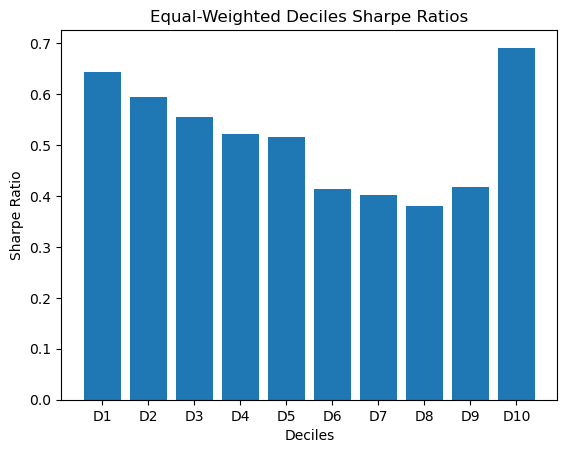

In [39]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part5/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

Equally weighted factor strategy

In [40]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean() * 12
short_mean = short_leg['Rn'].mean() *12

long_mean_e = long_leg['excess'].mean() *12
short_mean_e = short_leg['excess'].mean() * 12

long_std = long_leg['Rn'].std() * np.sqrt(12)
short_std = short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg.set_index("date") - short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18838092471362294
Short Leg Mean Return: 0.12746295506108274
Long Leg Standard Deviation: 0.2847856680879139
Short Leg Standard Deviation: 0.13886133567390535
Long Leg Sharpe Ratio: 0.46471865817413005
Short Leg Sharpe Ratio: 0.514378199963698
Factor Mean Return: 0.06091796965254023
Factor Standard Deviation: 0.20229139555685277
Factor Sharpe Ratio: 0.024134780752865393


Save factor for our investing strategy

In [41]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 7.659847971129943
P-Value: 9.325873406851315e-15
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [42]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['IV_ret_vw'] - rf['rf']

factor_mean = factor['IV_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['IV_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 1.1232571754919394
Short Leg Mean Return: 0.45218105520147844
Long Leg Standard Deviation: 0.9040733829613565
Short Leg Standard Deviation: 0.43442503908224983
Long Leg Sharpe Ratio: 1.180458892422643
Short Leg Sharpe Ratio: 0.9118842340804665
Factor Mean Return: 0.055923010024205064
Factor Standard Deviation: 0.20559546831145267
Factor Sharpe Ratio: 0.24929230127216098


In [43]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 6.918773949499266
P-Value: 2.2778445796234337e-12
The factor strategy has an average return that is statistically significantly different from zero.


In [44]:
# Merge factor dataframe with strat dataframe

strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')

# Drop all nans
strat = strat.dropna()

In [51]:
# rename columns to IV and MOM
strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
strat

,date,rf,BAB2,MOM,IV
35,1970-02-01,0.005253,0.028396,0.045441,0.139245
36,1970-03-01,0.005345,0.027196,0.070217,-0.119344
37,1970-04-01,0.005427,-0.040327,0.174635,-0.411660
38,1970-05-01,0.005257,-0.052312,0.005201,-0.127382
39,1970-06-01,0.004942,0.007012,0.201597,-0.101056
...,...,...,...,...,...
677,2023-08-01,0.004463,-0.015492,0.172734,0.027489
678,2023-09-01,0.004472,-0.043756,0.018452,0.027404
679,2023-10-01,0.004475,0.005475,-0.026999,-0.064254
680,2023-11-01,0.004455,0.034885,0.051445,-0.054103


## 6 Optimal Fund Portfolio Return (STRAT)